In [1]:
%matplotlib inline
%load_ext tensorboard

Imports

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pprint import pprint
from PIL import Image
from tqdm.notebook import tqdm
from copy import deepcopy
import pandas as pd

In [3]:
PATH = '/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test'#all_kanamycin_videos_jpg_crop/'
ANTIBIOTIC = 'kanamycin'
NUM_FRAMES = 40
X_DIM = 200
Y_DIM = 300

Forcing notebook to run on CPU - this isn't relevant if you haven't installed CUDA, or if you want to run on a GPU

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
# checking device code executes on
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0']


In [6]:
def loadVideoFrames(source):
    """Goes to the source folder and imports the frames as a list of np arrays which is returned"""
    frameList = os.listdir(source)[::10] # takes every tenth frame to maximise diversity
    frames = [np.asarray(Image.open(source + im).convert('L')) for im in frameList]
    return frames

In [7]:
def getXyData(XVidsList, yVidsList):
    """
    Uses the list of videos supplied to load the data from PATH, using loadVideoFrames, returns X and y
    datasets
    """
    
    XData, yData = [], []
    if len(XVidsList) == len(yVidsList):                                # check lists are same length
        for i in tqdm(range(len(XVidsList))):
            frames = loadVideoFrames(XVidsList[i] + '/')
            for frame in frames:
                XData.append(frame)                         # appending the image data to X_data
                yData.append(yVidsList[i])                # for each frame, adding the label to y
    else:
        print("X and y lists don't match length")
        return
    return XData, yData

Get lists of video names

In [8]:
def getVidLists():
    """
    Searches PATH for all relevant videos, ie those which are in folders containing the ANTIBIOTIC string and
    have been cropped (so end in 'crop' as per the preprocessing notebook). Adds the path to these video folders 
    to list of either resistant or susceptible videos, and then returns those lists.
    """
    dirs = os.listdir(PATH)
    antibioticDirs = []
    resVidList = []
    susVidList = []
    for dir_ in dirs:
        if dir_.startswith(ANTIBIOTIC) and dir_.endswith("crop"):
            antibioticDirs.append(dir_)

    for antibioticDir in antibioticDirs:
        for dir_ in os.listdir(os.path.join(PATH, antibioticDir)):
            dir_ = str(dir_)
            if dir_.endswith("resistant"):
                for vidFolder in os.listdir(os.path.join(PATH, antibioticDir, dir_)):
                    resVidList.append(os.path.join(PATH, antibioticDir, dir_, vidFolder))
            elif dir_.endswith("susceptible"):
                for vidFolder in os.listdir(os.path.join(PATH, antibioticDir, dir_)):
                    susVidList.append(os.path.join(PATH, antibioticDir, dir_, vidFolder))
            else:
                print("The folder {} within 'antibioticDir' is not either resistant or susceptible data".format(dir_))
    return resVidList, susVidList
                

In [9]:
(resVidList, susVidList) = getVidLists()
XVidsList = resVidList + susVidList 

yVidsList = [0 for i in range(np.shape(resVidList)[0])] + [1 for i in range(np.shape(susVidList)[0])]

Split videos into test:train:valid

In [10]:
XVidsTrainFull, XVidsTest, yVidsTrainFull, yVidsTest = train_test_split(XVidsList, yVidsList, test_size=0.2, random_state=42, stratify=yVidsList)
XVidsTrain, XVidsValid, yVidsTrain, yVidsValid = train_test_split(XVidsTrainFull, yVidsTrainFull, test_size=0.4, random_state=42, stratify=yVidsTrainFull)

Loading data

In [11]:
XTrain, yTrain = getXyData(XVidsTrain, yVidsTrain)
XValid, yValid = getXyData(XVidsValid, yVidsValid)
XTest, yTest = getXyData(XVidsTest, yVidsTest)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Data preparation

In [12]:
XTrain = np.asarray(XTrain)[..., np.newaxis]
XValid = np.asarray(XValid)[..., np.newaxis]
XTest = np.asarray(XTest)[..., np.newaxis]

yTrain = keras.utils.to_categorical(yTrain, num_classes=2)
yValid = keras.utils.to_categorical(yValid, num_classes=2)
yTest = keras.utils.to_categorical(yTest, num_classes=2)

The below cell downscales the images to half their current size (300x200 => 150x100). 
This can be used to reduce memory usage, although for final results we didn't downscale data, other than in the LSTM case.

Equally, if memory use is not an issue, commenting out this cell shouldn't prevent the remainder of the notebook from running nominally

In [13]:
X_DIM = 100
Y_DIM = 150
XTrain = [tf.image.resize(video, [X_DIM,Y_DIM], method='bicubic', preserve_aspect_ratio=False) for video in XTrain]
XValid = [tf.image.resize(video, [X_DIM,Y_DIM], method='bicubic', preserve_aspect_ratio=False) for video in XValid]
XTest = [tf.image.resize(video, [X_DIM,Y_DIM], method='bicubic', preserve_aspect_ratio=False) for video in XTest]

In [14]:
# scaling pixel intensities
XTrain = np.asarray(XTrain, dtype=np.float32)/255.0
XValid = np.asarray(XValid, dtype=np.float32)/255.0
XTest = np.asarray(XTest, dtype=np.float32)/255.0

In [15]:
from sklearn.utils import shuffle

# shuffling the datasets

XTrain, yTrain = shuffle(XTrain, yTrain, random_state=42)
XValid, yValid = shuffle(XValid, yValid, random_state=42)
XTest, yTest = shuffle(XTest, yTest, random_state=42)

Plot random image, just to check data ok

[0. 1.]


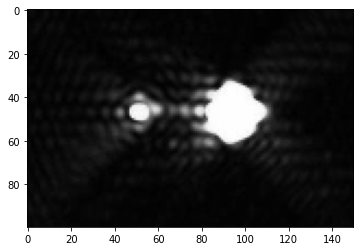

In [16]:
    from numpy.random import randint
    i = randint(800)
    print(yValid[i])
    plt.imshow(XValid[i], cmap='gray')

In [17]:
tf.keras.backend.clear_session()
# del model

In [18]:
root_logdir = os.path.join(os.curdir, "{}_logs".format(ANTIBIOTIC))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [19]:
# use this to switch between models, which should be saved in the same directory as eg. "CNN_model.py"

from CNN_model import model
model = model(X_DIM, Y_DIM)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 150, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 150, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 75, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 75, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 37, 128)       2

In [21]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(lr=0.005, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("h5_models/kanamycin_CNN_v3_11.h5", save_best_only=True)
history = model.fit(XTrain, yTrain, epochs=5, validation_data=(XValid, yValid), 
                    batch_size=32, callbacks=[tensorboard_cb, checkpoint_cb]) 

Epoch 1/5
152/152 [==============================] - 388s 3s/step - loss: 0.7753 - accuracy: 0.6551 - val_loss: 0.5823 - val_accuracy: 0.7570
Epoch 2/5
152/152 [==============================] - 387s 3s/step - loss: 0.5938 - accuracy: 0.7255 - val_loss: 0.4717 - val_accuracy: 0.7598
Epoch 3/5
152/152 [==============================] - 387s 3s/step - loss: 0.4916 - accuracy: 0.7682 - val_loss: 0.3407 - val_accuracy: 0.8689
Epoch 4/5
152/152 [==============================] - 387s 3s/step - loss: 0.4669 - accuracy: 0.7968 - val_loss: 0.6050 - val_accuracy: 0.6549
Epoch 5/5
152/152 [==============================] - 387s 3s/step - loss: 0.3814 - accuracy: 0.8408 - val_loss: 0.4630 - val_accuracy: 0.7660


The next section of the notebook is dedicated to assessing model performance against various metrics, and seeing how performance evolved per epoch.

In [18]:
# loading best model checkpoint based on validation loss
model = keras.models.load_model("h5_models/kanamycin_CNN_v3_11.h5")

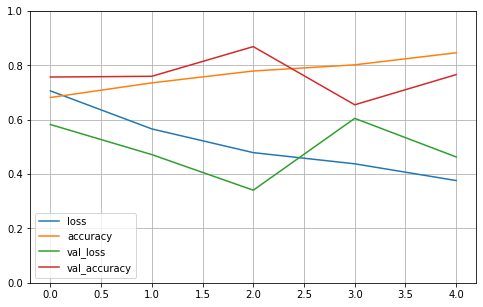

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

In [24]:
%tensorboard --logdir=./kanamycin_logs --port=6006

In [25]:
score = model.evaluate(XTest, yTest)

64/64 [==============================] - 17s 266ms/step - loss: 0.4038 - accuracy: 0.7573


In [26]:
yProbs = model.predict(XTest)

yPreds = (yProbs > 0.5) 

yPreds = yPreds.astype(float)

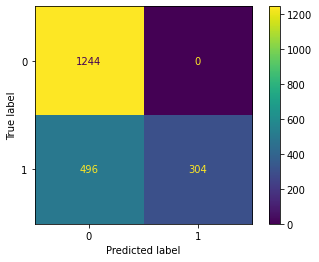

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confm = confusion_matrix(yTest.argmax(axis=1), yPreds.argmax(axis=1))
disp = ConfusionMatrixDisplay(confm)
disp.plot()

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(yTest.ravel(), yProbs.ravel())

In [29]:
def plotRocCurve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
   

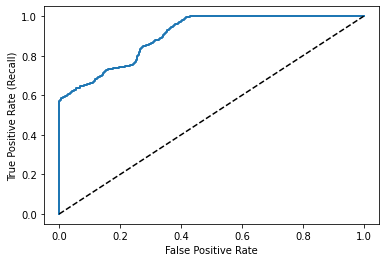

In [30]:
plotRocCurve(fpr, tpr)
plt.show()

In [39]:
# this enables you to compare ROC curves using the ROC curve builder in the util folder
# filepath will need to be changed to wherever you want to store your results
np.save(os.path.join('/home/gabriel/Documents/Uni/Year 4/Project/kanamycin/results/cnn_big', 'fpr.npy'),fpr)
np.save(os.path.join('/home/gabriel/Documents/Uni/Year 4/Project/kanamycin/results/cnn_big', 'tpr.npy'),tpr)

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(yTest, yPreds, average=None))
print(recall_score(yTest, yPreds, average=None))
print(f1_score(yTest, yPreds, average=None))

[0.71494253 1.        ]
[1.   0.38]
[0.83378016 0.55072464]


The following final section of the notebook enables the visualisation of layer responses in the network. This section was written by Hollie Hindley, and I've not had time to do any cleanup/refactoring so it's not the neatest - apologies.

In [20]:
import matplotlib.pylab as plt
import itertools
import numpy as np
from tensorflow.keras import backend as K


def visualise_img_in_layer(model, layer, img_to_visualize, zoom_id=-1):
    inputs = [K.learning_phase()] + tf.keras.Input((100,150,1))
    # inputs = model.inputs + [K.learning_phase()]

    _convout1_f = K.function(inputs, [layer.output])

    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    # change from channel-last to channel-first
    print ('Shape of conv:', convolutions.shape)
    convolutions = convolutions.transpose(2, 0, 1)
    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(20, 20))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n, n, i + 1)
        ax.imshow(convolutions[i], interpolation="none")
        ax.axis('off')
    plt.tight_layout(pad=-1.1, w_pad=-1.1, h_pad=-1.1)
    plti(convolutions[zoom_id])
    
    

In [19]:
layer_names = [layer.name for layer in model.layers]

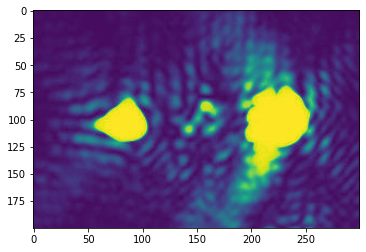

In [22]:
# kana susceptible video49 frame 200
source = PATH + '/kanamycin_videos_jpg_crop/treated_susceptible/video49/video0200.jpeg'
susceptible_frame = np.asarray(Image.open(source).convert('L'))
plt.imshow(susceptible_frame)
susceptible_frame_sml = tf.image.resize(susceptible_frame[..., np.newaxis], [X_DIM,Y_DIM], method='bicubic', preserve_aspect_ratio=False)
susceptible_frame_sml = np.asarray(susceptible_frame_sml, dtype=np.float32)/255.0
# plt.imshow(susceptible_frame_sml)

In [23]:
visualise_img_in_layer(model, model.layers[1], susceptible_frame_sml)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: tf.__operators__.add/AddV2:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 100, 150, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'") at layer "conv2d". The following previous layers were accessed without issue: []

In [24]:
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
feature_maps = feature_map_model.predict(susceptible_frame_sml[np.newaxis, ...])

conv2d


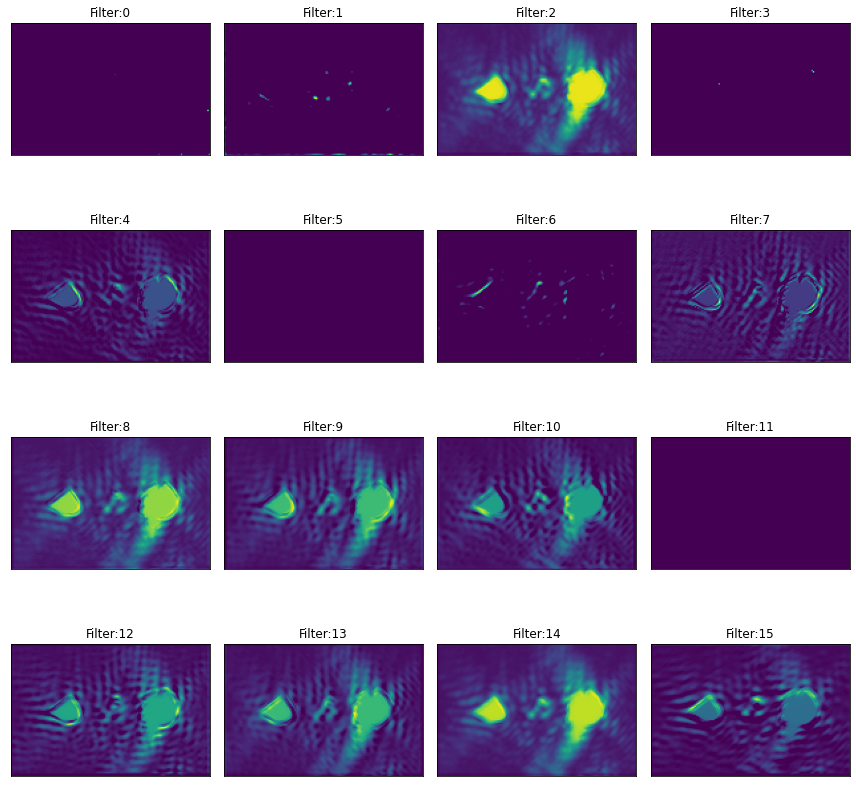

In [25]:
print(layer_names[0])
layer1_map = feature_maps[0]
num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for layer in (range(16)):
    num=16
    images = layer1_map[0,:,:,layer]
    labels = layer
    num_row = 4
    num_col = 4
    ax = axes[layer//num_col, layer%num_col]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(images, cmap='viridis')
    ax.set_title('Filter:{}'.format(labels))
plt.tight_layout()
plt.show()

[[0.11688101 0.883119  ]]
[0.11688101]
tf.Tensor(0.116881005, shape=(), dtype=float32)
(1, 100, 150, 1)


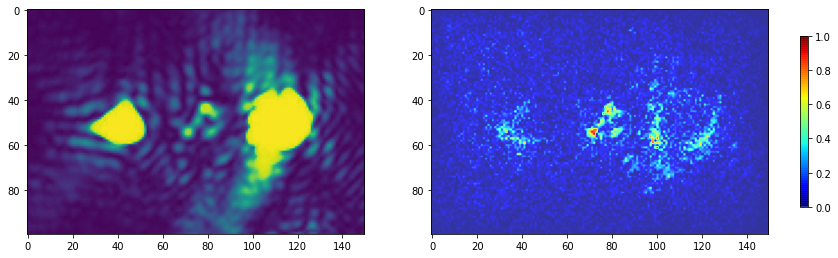

In [26]:
sus_frame_sml_tensor = np.expand_dims(susceptible_frame_sml, axis=0)
y_pred = model.predict([[sus_frame_sml_tensor]])
print(y_pred)
images = tf.Variable(sus_frame_sml_tensor, dtype=np.float32)

with tf.GradientTape() as tape:
    tape.watch(images)
    pred = model(images, training=False)[:,0]
    class_idxs_sorted = pred.numpy().flatten()[::-1]
    print(class_idxs_sorted)
    loss = pred[0]
    print(loss)
    
grads = tape.gradient(loss, images)
dgrad_abs = tf.math.abs(grads)
dgrad_max = np.max(dgrad_abs, axis=3)[0]
arr_min, arr_max = np.min(dgrad_max), np.max(dgrad_max)
grad_eval = (dgrad_max - arr_min)/(arr_max - arr_min + 1e-18)
fig, axes = plt.subplots(1,2,figsize=(14,5))
print(np.shape(sus_frame_sml_tensor))
axes[0].imshow(sus_frame_sml_tensor[0,:,:,:])                 

i = axes[1].imshow(grad_eval,cmap='jet',alpha=0.8)
fig.colorbar(i, ax=axes, fraction=0.0109, pad=0.04)

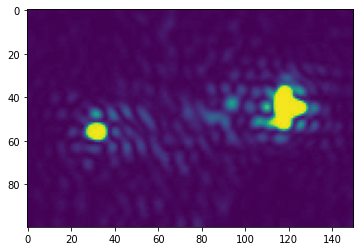

In [30]:
# kana resistant video73 frame 200
source = os.path.join(PATH, 'kanamycin_videos_jpg_crop/treated_resistant/video73/video0200.jpeg')
resistant_frame = np.asarray(Image.open(source).convert('L'))
resistant_frame_sml = tf.image.resize(resistant_frame[..., np.newaxis], [X_DIM,Y_DIM], method='bicubic', preserve_aspect_ratio=False)
resistant_frame_sml = np.asarray(resistant_frame_sml, dtype=np.float32)/255.0
plt.imshow(resistant_frame_sml)

[[0.808085 0.191915]]
[0.808085]
tf.Tensor(0.808085, shape=(), dtype=float32)
(1, 100, 150, 1)


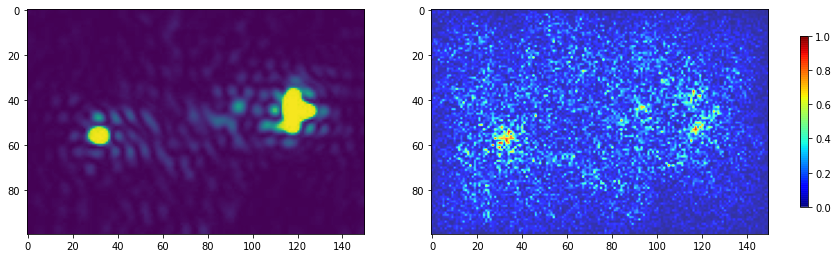

In [31]:
res_frame_sml_tensor = np.expand_dims(resistant_frame_sml, axis=0)
y_pred = model.predict([[res_frame_sml_tensor]])
print(y_pred)
images = tf.Variable(res_frame_sml_tensor, dtype=np.float32)

with tf.GradientTape() as tape:
    tape.watch(images)
    pred = model(images, training=False)[:,0]
    class_idxs_sorted = pred.numpy().flatten()[::-1]
    print(class_idxs_sorted)
    loss = pred[0]
    print(loss)
    
grads = tape.gradient(loss, images)
dgrad_abs = tf.math.abs(grads)
dgrad_max = np.max(dgrad_abs, axis=3)[0]
arr_min, arr_max = np.min(dgrad_max), np.max(dgrad_max)
grad_eval = (dgrad_max - arr_min)/(arr_max - arr_min + 1e-18)
fig, axes = plt.subplots(1,2,figsize=(14,5))
print(np.shape(res_frame_sml_tensor))
axes[0].imshow(res_frame_sml_tensor[0,:,:,:])                 

i = axes[1].imshow(grad_eval,cmap='jet',alpha=0.8)
fig.colorbar(i, ax=axes, fraction=0.0109, pad=0.04)